# 載入必要的套件
- google colab drive
- pip install
- import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import package
!pip install opencv-python torch torchvision matplotlib
!pip install grad-cam

In [ ]:
# check the file path
yolov5_path = '/content/drive/MyDrive/yolov5-master'
# yolov5_path = '/content/yolov5'

import sys
sys.path.append(yolov5_path)

import os
# import packages
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from PIL import Image
from models.experimental import attempt_load
from utils.torch_utils import select_device
# from models.yolo import Model
import cv2
import numpy as np

# 寫好的程式碼，僅須執行下列即可

In [ ]:
# !python /content/drive/MyDrive/yolov5-master/main_gradcam.py --img-path /content/drive/MyDrive/yolov5-master/data/images
!python /content/drive/MyDrive/yolov5-master/GradCam_winnie.py


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1    656896  

In [ ]:
# 確認model跟輸出結果是正常的
!python /content/drive/MyDrive/yolov5-master/detect.py --weight /content/drive/MyDrive/yolov5-master/data/best.pt --source /content/drive/MyDrive/yolov5-master/data/images/test.png

detect: weights=['/content/drive/MyDrive/yolov5-master/data/best.pt'], source=/content/drive/MyDrive/yolov5-master/data/images/test.png, data=drive/MyDrive/yolov5-master/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=drive/MyDrive/yolov5-master/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2023-11-22 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 224 layers, 7053910 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/yolov5-master/data/images/test.png: 640x640 2 arcades, 704.7ms
Speed: 4.0ms pre-process, 704.7ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to drive/MyDrive/yolov5-master/runs/detect/exp


# 載入訓練好的模型權重檔best.pt及影像test.img


In [ ]:
# 載入最好模型(best.pt)
model_path = '/content/drive/MyDrive/yolov5-master/data/best.pt'
model = attempt_load(model_path)
# device = select_device("cuda" if torch.cuda.is_available() else "cpu")
device = select_device("cpu")
model

Fusing layers... 
YOLOv5s summary: 224 layers, 7053910 parameters, 0 gradients
YOLOv5 🚀 2023-11-22 Python-3.10.12 torch-2.1.0+cu118 CPU



DetectionModel(
  (model): Sequential(
    (0): Focus(
      (conv): Conv(
        (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv3): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): Sequential(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3),

In [ ]:
# 載入並預處理圖片
img_path = "/content/drive/MyDrive/yolov5-master/data/images/test.png"
img = Image.open(img_path).convert("RGB")
img_tensor = ToTensor()(img).unsqueeze(0).to(device)  # 將圖片轉換為tensor並移至適當的設備
print(img_tensor.shape)

torch.Size([1, 3, 640, 640])


In [ ]:
# 載入並預處理圖片 (根據template所做的_測試階段)
# img_path = "/content/drive/MyDrive/yolov5/data/arcade/images/valid/6DFXjgQtCFRwVS8LUwylmA$I$Y$.png"
# img = np.array(Image.open(img_path))
# rgb_img = img.copy()
# img = np.float32(img) / 255
# transform = transforms.ToTensor()
# tensor = transform(img).unsqueeze(0)
# model.eval()
# model.cpu()

# 選擇target layer及建立CAM


In [ ]:
# name of each layer 以利於後續挑target layers
for name, module in model.named_modules():
    print(name)
    print(f'-----------')

In [ ]:
# target_layers = [model.model[-2]] # turn targer_layers to list
# target_layers = model.model[-2].cv1.conv
# target_layers = [model.model[-2].cv2.conv]
# model.model # print出來是模型架構
target_layers = [model.model[-2]]   #[-4]對應到21層
target_layers

[C3(
   (cv1): Conv(
     (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
     (act): SiLU(inplace=True)
   )
   (cv2): Conv(
     (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
     (act): SiLU(inplace=True)
   )
   (cv3): Conv(
     (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
     (act): SiLU(inplace=True)
   )
   (m): Sequential(
     (0): Bottleneck(
       (cv1): Conv(
         (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (act): SiLU(inplace=True)
       )
     )
   )
 )]

In [ ]:
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
cam

In [ ]:
# results = prediction
model.eval()
model.cpu()
results = model(img_tensor)

# results = tuple with 2 items
tensor1 = results[0]
list2 = results[1]

print(type(results[0]))
print(type(results[1]))

print(tensor1.size())
print(tensor1)

# model prediction
# with torch.no_grad():
#     prediction = model(img_tensor)
# prediction

<class 'torch.Tensor'>
<class 'list'>
torch.Size([1, 25200, 6])
tensor([[[6.93182e+00, 7.61802e+00, 1.25016e+01, 1.64558e+01, 7.43688e-06, 9.87812e-01],
         [1.04176e+01, 7.89817e+00, 1.72844e+01, 1.34186e+01, 1.29690e-05, 9.87753e-01],
         [1.85631e+01, 6.60838e+00, 2.71337e+01, 1.23193e+01, 3.13221e-06, 9.87471e-01],
         ...,
         [5.66439e+02, 6.20233e+02, 1.26107e+02, 6.73530e+01, 8.78364e-06, 9.83408e-01],
         [5.90274e+02, 6.19690e+02, 1.13737e+02, 6.78232e+01, 4.33469e-06, 9.85066e-01],
         [6.12397e+02, 6.18735e+02, 1.05496e+02, 7.15098e+01, 5.44156e-06, 9.86448e-01]]])


In [ ]:
# 探討result[1]的內容
print(f'result[1]:有 {len(list2)} value')  # 共有3個value
for idx, item in enumerate(list2):
    print(f"Item {idx + 1} type: {type(item)}")  #把每個value的type印出

# print result[1]的value維度
for idx, item in enumerate(list2):
    if torch.is_tensor(item):
        print(f"Item {idx + 1} size: {item.size()}")
    else:
        print(f"Item {idx + 1} is not a tensor")

result[1]:有 3 value
Item 1 type: <class 'torch.Tensor'>
Item 2 type: <class 'torch.Tensor'>
Item 3 type: <class 'torch.Tensor'>
Item 1 size: torch.Size([1, 3, 80, 80, 6])
Item 2 size: torch.Size([1, 3, 40, 40, 6])
Item 3 size: torch.Size([1, 3, 20, 20, 6])


In [ ]:
# check GPU
if not torch.cuda.is_available():
    print("CUDA is not available. Please check your runtime settings.")
else:
    print("CUDA is available. GPU will be used.")

CUDA is available. GPU will be used.


# 用keras的方法用看看

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
img_array = np.array(img) # size = 640*640*3

from PIL import Image
def get_img_array(img_path, size):
    # `img` is a PIL image of size 640*640
    img = Image.open(img_path).convert("RGB")
    # `array` is a float32 Numpy array of shape (640, 640, 3)
    array = np.array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 640, 640, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
img_size = (640, 640)
test = get_img_array(img_path, size=img_size)

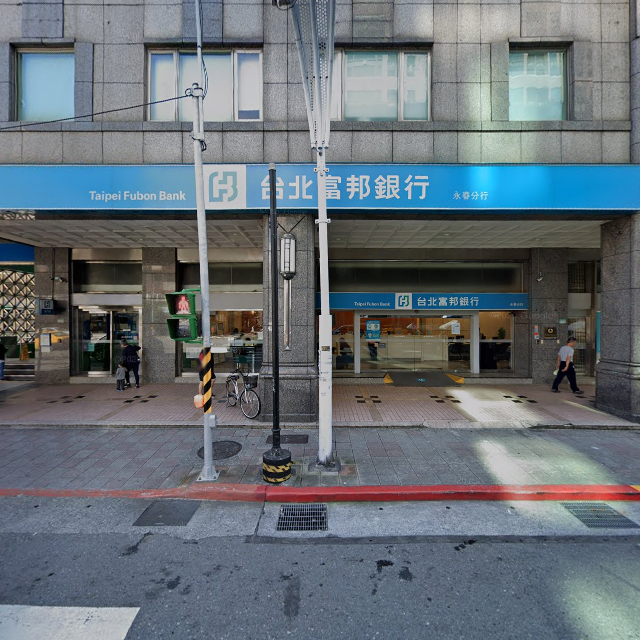

In [ ]:
img